In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import xroms
# from cartopy import geodesic  # FS only way to get this module
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import numpy as np
import cmocean.cm as cmo
from xgcm import Grid
import cmocean.cm as cmo
import matplotlib.gridspec as gridspec

In [2]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=3)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
def load_roms():
    # A basic chunk choice
    chunks = {'ocean_time': 10}
    # def preprocessRemoveLastDay(ds):
    #     '''remove the last 7 timesteps from each file'''
    #     return ds.isel(ocean_time = slice(0,-1))
    glb_files = glob('/g/data/fu5/HSM/outer_avg_*.nc')
    ds = xr.open_mfdataset(glb_files, chunks=chunks, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right')
    print('Loading data: OK!')
    return ds




def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def rho_eos(Tt,Ts,z_r):
    #     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # %
    # % function [rho,bvf]=rho_eos(Tt,Ts,z_r)
    # %
    # % Computes density via Equation Of State (EOS) for seawater.
    # % If so prescribed, non-linear EOS of Jackett and McDougall (1995)
    # % is used.
    # %
    # % Tt potential temperature [deg Celsius].
    # % Ts salinity [PSU].
    # % Tz pressure/depth, [depth in meters and negative].
    # %
    # % K0, K1 and K2 are the pressure polynomial coefficients for secant
    # % bulk modulus, so that
    # %
    # %               bulk = K0 - K1 * z + K2 * z**2 ;
    # %
    # % while rho1 is sea-water density [kg/m^3] at standard pressure
    # % of 1 Atm, so that the density anomaly at in-sity pressure is
    # %
    # %               rho = rho1 / (1 + z / bulk) - 1000
    # %
    # %  Reference:
    # %
    # %  Jackett, D. R. and T. J. McDougall, 1995, Minimal Adjustment of
    # %  Hydrostatic Profiles to Achieve Static Stability, Journ of Atmos.
    # %  and Oceanic Techn., vol. 12, pp. 381-389.
    # %
    # % << This equation of state formulation has been derived by Jackett
    # %    and McDougall (1992), unpublished manuscript, CSIRO, Australia.
    # %    It computes in-situ density anomaly as a function of potential
    # %    temperature (Celsius) relative to the surface, salinity (PSU),
    # %    and depth (meters).  It assumes  no  pressure  variation along
    # %    geopotential  surfaces,  that  is,  depth  and  pressure  are
    # %    interchangeable. >>
    # %                                          John Wilkin, 29 July 92
    # %
    # % Check Values: T=3 C S=35.5 PSU Z=-5000 m rho=1050.3639165364 
    
    import numpy as np
    
    A00=+19092.56;A01=+209.8925;
    A02=-3.041638;A03=-1.852732e-3;A04=-1.361629e-5;A10=104.4077;
    A11=-6.500517;A12=+0.1553190;A13=2.326469e-4;AS0=-5.587545;
    AS1=+0.7390729;AS2=-1.909078e-2;B00=+4.721788e-1;B01=+1.028859e-2;
    B02=-2.512549e-4;B03=-5.939910e-7;B10=-1.571896e-2;B11=-2.598241e-4;
    B12=+7.267926e-6;BS1=+2.042967e-3;E00=+1.045941e-5;E01=-5.782165e-10;
    E02=+1.296821e-7;E10=-2.595994e-7;E11=-1.248266e-9;E12=-3.508914e-9;

    QR=+999.842594;Q01=+6.793952e-2;Q02=-9.095290e-3;
    Q03=+1.001685e-4;Q04=-1.120083e-6;Q05=+6.536332e-9;Q10=+0.824493;
    Q11=-4.08990e-3;Q12=+7.64380e-5;Q13=-8.24670e-7;Q14=+5.38750e-9;
    QS0=-5.72466e-3;QS1=+1.02270e-4;QS2=-1.65460e-6;Q20=+4.8314e-4;
    
    
    sqrtTs=np.sqrt(Ts);

    K0=A00+Tt*(A01+Tt*(A02+Tt*(A03+Tt*A04)))+Ts*(A10+Tt*(A11+Tt*(A12+Tt*A13))+sqrtTs*(AS0+Tt*(AS1+Tt*AS2)));
    K1=B00+Tt*(B01+Tt*(B02+Tt*B03))+Ts*(B10+Tt*(B11+Tt*B12)+sqrtTs*BS1);
    K2=E00+Tt*(E01+Tt*E02)+Ts*(E10+Tt*(E11+Tt*E12));
    rho1=QR+Tt*(Q01+Tt*(Q02+Tt*(Q03+Tt*(Q04+Tt*Q05))))+Ts*(Q10+Tt*(Q11+Tt*(Q12+Tt*(Q13+Tt*Q14)))+sqrtTs*(QS0+Tt*(QS1+Tt*QS2))+Ts*Q20);
    rho=rho1/(1+0.1*z_r/(K0-z_r*(K1-z_r*K2)));
    
    return rho


#### load data, make grid file, correct vertical coordinate


In [4]:
ds = load_roms()

ds = processROMSGrid(ds)
grid = makeROMSGridObject(ds)

Loading data: OK!


In [5]:
ds

<xarray.Dataset>
Dimensions:         (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 479, xi_rho: 199, xi_u: 198, eta_v: 478, ocean_time: 638)
Coordinates: (12/14)
  * s_rho           (s_rho) float64 -0.9715 -0.9156 ... -0.0156 -0.004799
  * s_w             (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(479, 199), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 dask.array<chunksize=(479, 199), meta=np.ndarray>
    lon_u           (eta_rho, xi_u) float64 dask.array<chunksize=(479, 198), meta=np.ndarray>
    lat_u           (eta_rho, xi_u) float64 dask.array<chunksize=(479, 198), meta=np.ndarray>
    ...              ...
    lon_psi         (eta_v, xi_u) float64 dask.array<chunksize=(478, 198), meta=np.ndarray>
    lat_psi         (eta_v, xi_u) float64 dask.array<chunksize=(478, 198), meta=np.ndarray>
  * ocean_time      (ocean_time) datetime64[ns] 2017-05-31T12:00:00 ... 2019-...
    z_w             (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(10, 31, 479, 199), meta=np.ndarray>
    z_rho           (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(10, 30, 479, 199), meta=np.ndarray>
    z_rho0          (eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(479, 199, 30), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/108)
    ntimes          int32 ...
    ndtfast         int32 ...
    dt              float64 ...
    dtfast          float64 ...
    dstart          datetime64[ns] ...
    nHIS            int32 ...
    ...              ...
    dz_w            (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(10, 1, 479, 199), meta=np.ndarray>
    dz_u            (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(10, 30, 479, 198), meta=np.ndarray>
    dz_w_u          (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(10, 1, 479, 198), meta=np.ndarray>
    dz_v            (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(10, 30, 478, 199), meta=np.ndarray>
    dz_w_v          (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(10, 1, 478, 199), meta=np.ndarray>
    dA              (eta_rho, xi_rho) float64 dask.array<chunksize=(479, 199), meta=np.ndarray>
Attributes: (12/31)
    file:              outer_avg.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             EAC COASTAL GRID WITH TIDES
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            010x024
    history:           ROMS/TOMS, Version 3.9, Saturday - August 7, 2021 -  2...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       COASTAL_TIDE, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BT...

In [6]:
# ds = xr.open_mfdataset('/g/data/fu5/deg581/OSSE_SSHSST_XBT_PXLINES/output/roms_fwd_outer1_08529.nc')
# ds = processROMSGrid(ds)
ds.nbytes/1e9

192.878371708

In [7]:
# (ds.z_w.isel(s_w=-1,ocean_time=0)-ds.z_w.isel(s_w=-2,ocean_time=0)).plot(x='lon_rho',y='lat_rho')
ds = ds.drop_vars(['salt','ubar','vbar','ubar_eastward','vbar_northward','w','zeta','z_u','z_v','dz_w','dz_u','dz_w_u','dz_v','dz_w_v','dz','z_w'])

ds.nbytes/1e9

43.833864668

In [12]:
ds = ds.sel(ocean_time=slice('2018-01-01','2018-06-01'))

ds.nbytes/1e9

10.47913646

In [9]:
ds

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 479, xi_rho: 199, xi_u: 198, eta_v: 478, ocean_time: 366)
Coordinates: (12/13)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(479, 199), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(479, 199), meta=np.ndarray>
    lon_u          (eta_rho, xi_u) float64 dask.array<chunksize=(479, 198), meta=np.ndarray>
    lat_u          (eta_rho, xi_u) float64 dask.array<chunksize=(479, 198), meta=np.ndarray>
    ...             ...
    lat_v          (eta_v, xi_rho) float64 dask.array<chunksize=(478, 199), meta=np.ndarray>
    lon_psi        (eta_v, xi_u) float64 dask.array<chunksize=(478, 198), meta=np.ndarray>
    lat_psi        (eta_v, xi_u) float64 dask.array<chunksize=(478, 198), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2018-01-01T12:00:00 ... 2019-0...
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(5, 30, 479, 199), meta=np.ndarray>
    z_rho0         (eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(479, 199, 30), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/93)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    dx_psi         (eta_v, xi_u) float64 dask.array<chunksize=(478, 198), meta=np.ndarray>
    dy             (eta_rho, xi_rho) float64 dask.array<chunksize=(479, 199), meta=np.ndarray>
    dy_u           (eta_rho, xi_u) float64 dask.array<chunksize=(479, 198), meta=np.ndarray>
    dy_v           (eta_v, xi_rho) float64 dask.array<chunksize=(478, 199), meta=np.ndarray>
    dy_psi         (eta_v, xi_u) float64 dask.array<chunksize=(478, 198), meta=np.ndarray>
    dA             (eta_rho, xi_rho) float64 dask.array<chunksize=(479, 199), meta=np.ndarray>
Attributes: (12/31)
    file:              outer_avg.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             EAC COASTAL GRID WITH TIDES
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            010x024
    history:           ROMS/TOMS, Version 3.9, Saturday - August 7, 2021 -  2...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       COASTAL_TIDE, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BT...

In [10]:
# ds.z_rho0.isel(s_rho=13).plot(x='lon_rho',y='lat_rho')
# plt.show()
# ds.z_rho0.isel(s_rho=13).plot()

# plt.show()
# (ds.z_w.isel(s_w=-13,ocean_time=0)-ds.z_w.isel(s_w=-14,ocean_time=0)).plot(x='lon_rho',y='lat_rho')

In [11]:
# ds.z_rho0.isel(eta_rho=120,xi_rho=100).values

In [13]:
ds.load()

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 479, xi_rho: 199, xi_u: 198, eta_v: 478, ocean_time: 152)
Coordinates: (12/13)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 150.8 150.8 150.8 ... 153.9 153.9
    lat_rho        (eta_rho, xi_rho) float64 -34.53 -34.54 ... -32.26 -32.26
    lon_u          (eta_rho, xi_u) float64 150.8 150.8 150.8 ... 153.9 153.9
    lat_u          (eta_rho, xi_u) float64 -34.53 -34.54 ... -32.26 -32.26
    ...             ...
    lat_v          (eta_v, xi_rho) float64 -34.53 -34.53 ... -32.26 -32.27
    lon_psi        (eta_v, xi_u) float64 150.8 150.8 150.8 ... 153.9 153.9 153.9
    lat_psi        (eta_v, xi_u) float64 -34.53 -34.53 -34.54 ... -32.26 -32.27
  * ocean_time     (ocean_time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-0...
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 ... -0.4906
    z_rho0         (eta_rho, xi_rho, s_rho) float64 nan nan ... -2.13 -0.1011
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/93)
    ntimes         int32 81000
    ndtfast        int32 15
    dt             float64 32.0
    dtfast         float64 2.133
    dstart         datetime64[ns] 2017-05-31T12:00:00
    nHIS           int32 81000
    ...             ...
    dx_psi         (eta_v, xi_u) float64 750.0 750.0 750.0 ... 750.0 750.0 750.0
    dy             (eta_rho, xi_rho) float64 750.0 750.0 749.9 ... 745.1 745.1
    dy_u           (eta_rho, xi_u) float64 750.0 750.0 749.9 ... 745.1 745.1
    dy_v           (eta_v, xi_rho) float64 750.0 750.0 749.9 ... 745.1 745.1
    dy_psi         (eta_v, xi_u) float64 750.0 750.0 749.9 ... 745.2 745.1 745.1
    dA             (eta_rho, xi_rho) float64 5.625e+05 5.625e+05 ... 5.588e+05
Attributes: (12/31)
    file:              outer_avg.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             EAC COASTAL GRID WITH TIDES
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            010x024
    history:           ROMS/TOMS, Version 3.9, Saturday - August 7, 2021 -  2...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       COASTAL_TIDE, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BT...

#### Simple plots of domain

Text(0.5, 1.0, '')

<Figure size 432x288 with 0 Axes>

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/shapefile.py:391: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


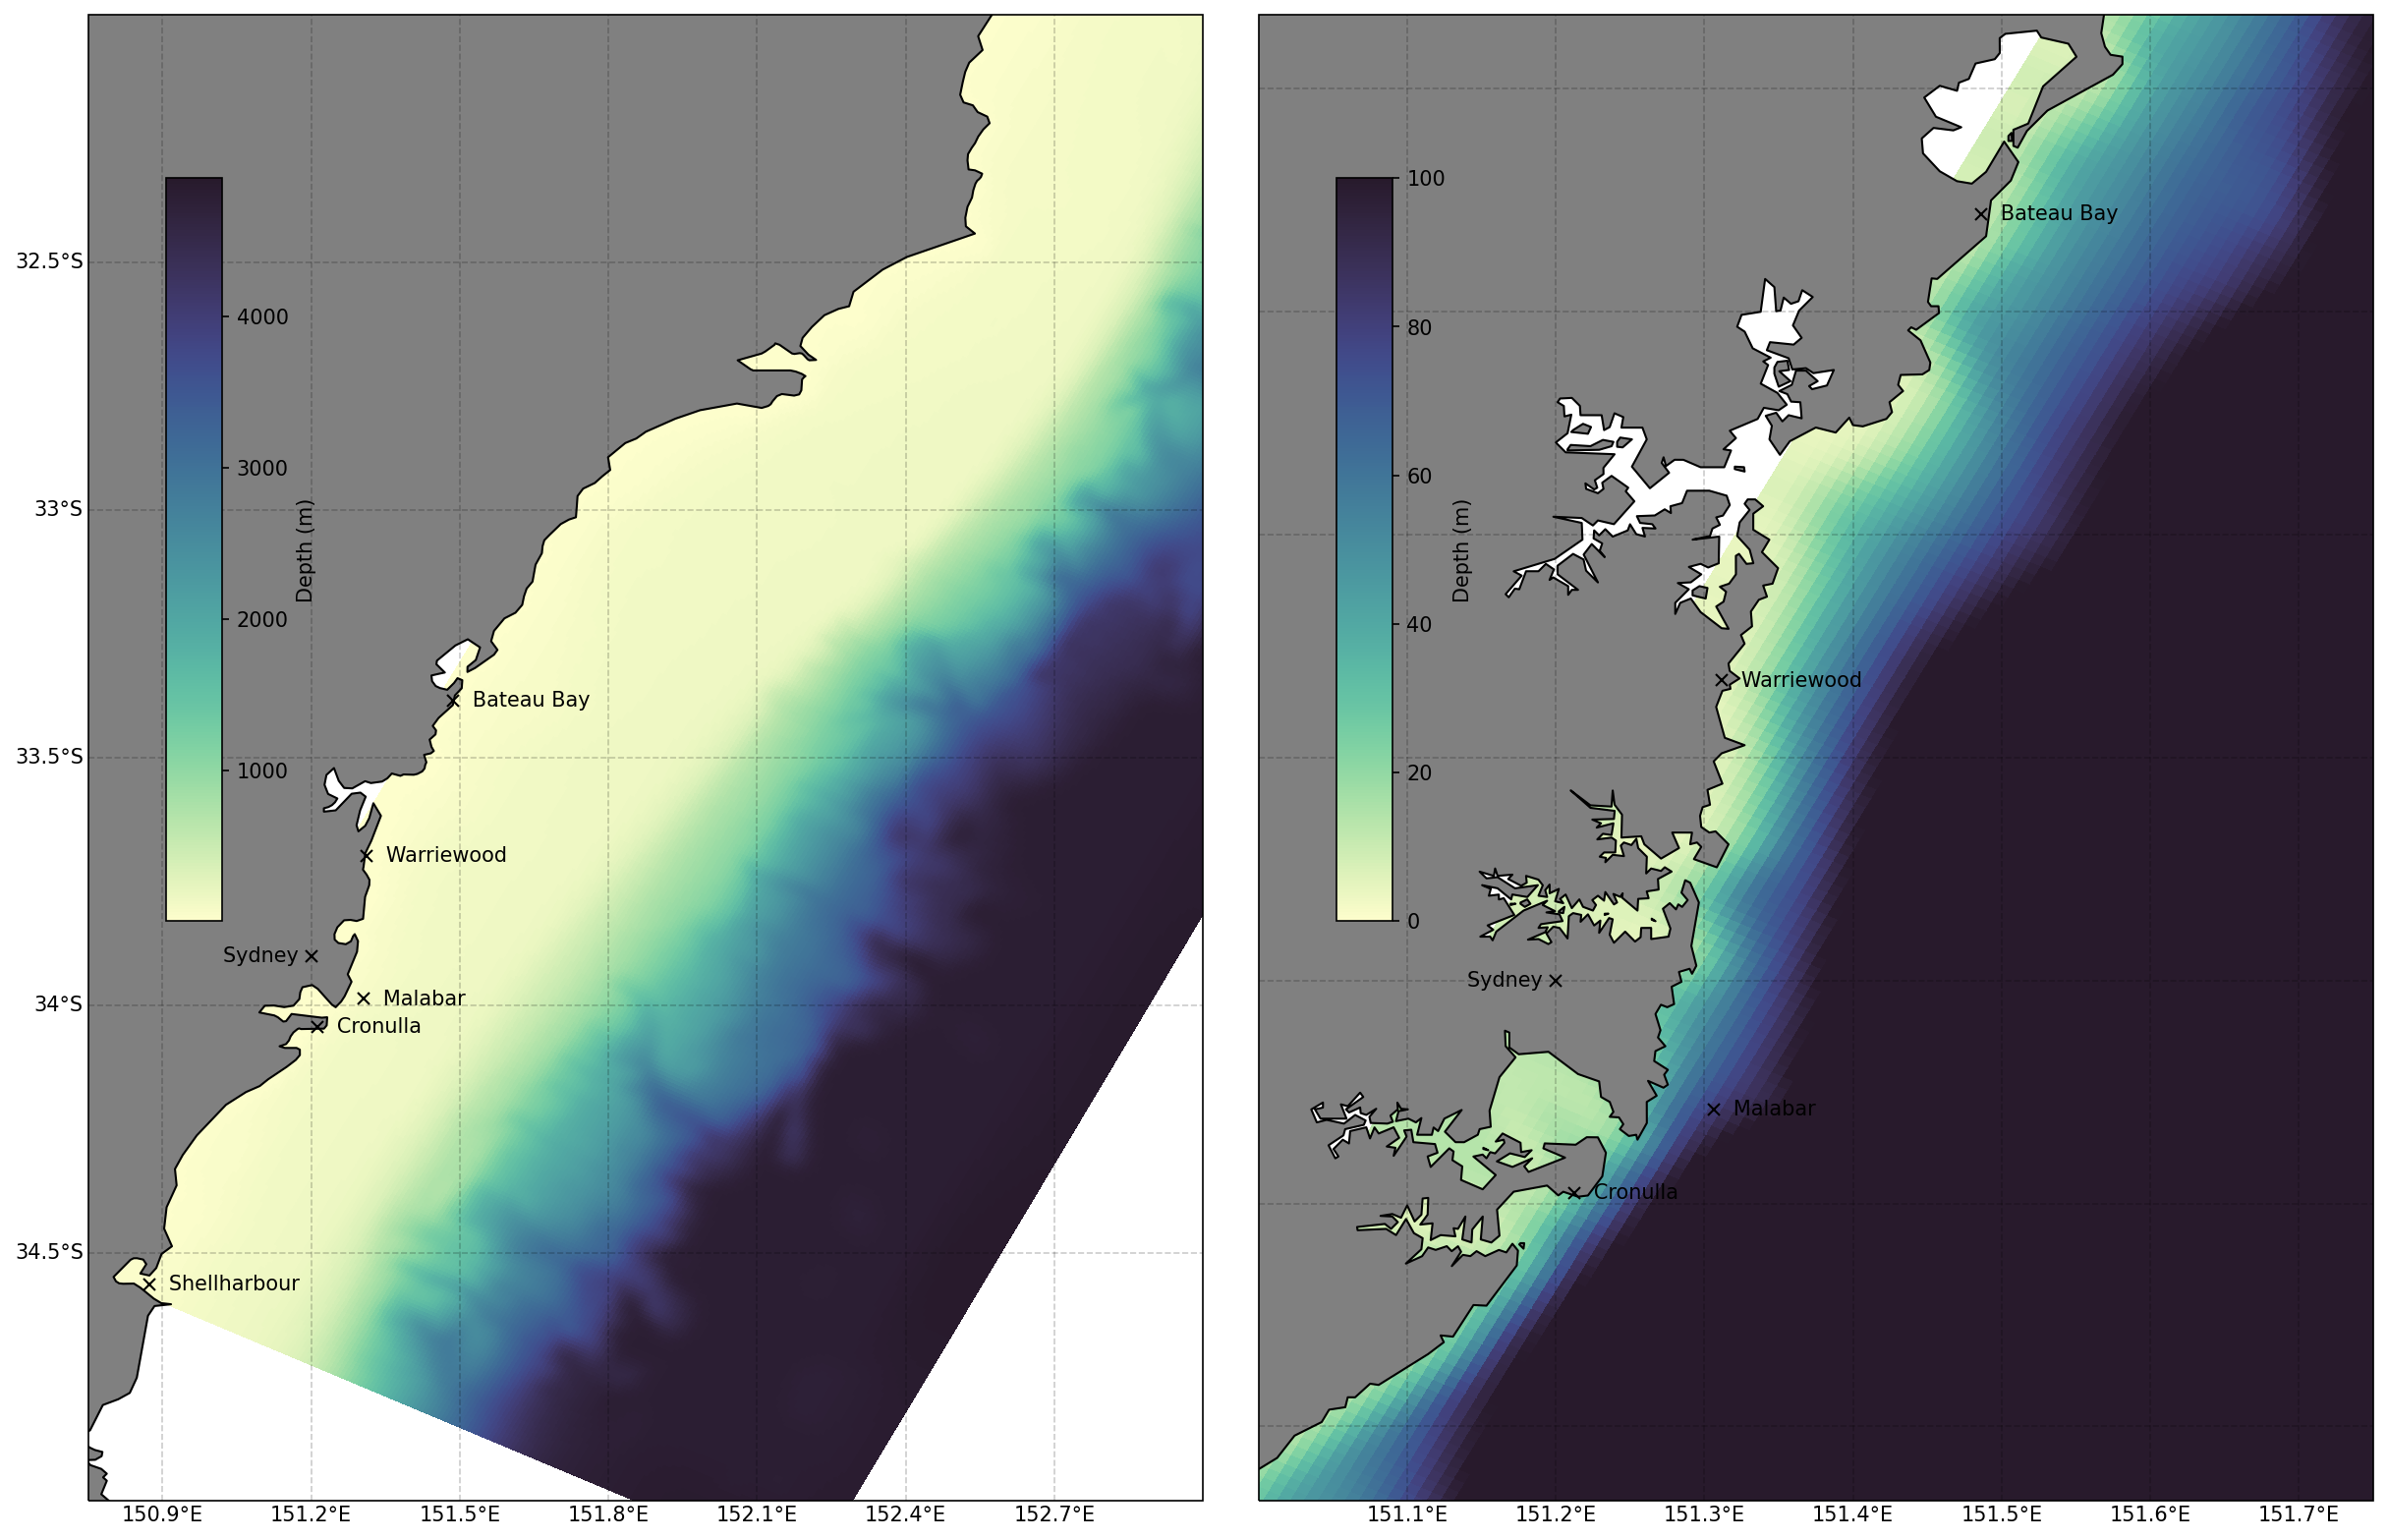

In [14]:
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
coastHR = cfeature.GSHHSFeature(scale='auto')

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,20],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([150.75, 153, -35, -32])
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im = ds.h.plot(x='lon_rho',y='lat_rho',cmap='cmo.deep', add_colorbar=False)     

ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')
ax.text(151.486467,-33.384367,'   Bateau Bay  ',ha='left',va='center'), ax.plot(151.486467,-33.384367,marker='x',color='k')
ax.text(151.311883,-33.69805,'   Warriewood  ',ha='left',va='center'), ax.plot(151.311883,-33.69805,marker='x',color='k')
ax.text(151.306667,-33.987,'   Malabar  ',ha='left',va='center'), ax.plot(151.306667,-33.987,marker='x',color='k')
ax.text(151.212333,-34.043083,'   Cronulla  ',ha='left',va='center'), ax.plot(151.212333,-34.043083,marker='x',color='k')
ax.text(150.87365,-34.563683,'   Shellharbour  ',ha='left',va='center'), ax.plot(150.87365,-34.563683,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax.set_title('')  

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax.set_extent([151, 151.75, -34.25, -33.25])
feature = ax.add_feature(coastHR, edgecolor='black',facecolor='gray')
im = ds.h.plot(x='lon_rho',y='lat_rho',cmap='cmo.deep', add_colorbar=False,vmin=0,vmax=100)     

ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')
ax.text(151.486467,-33.384367,'   Bateau Bay  ',ha='left',va='center'), ax.plot(151.486467,-33.384367,marker='x',color='k')
ax.text(151.311883,-33.69805,'   Warriewood  ',ha='left',va='center'), ax.plot(151.311883,-33.69805,marker='x',color='k')
ax.text(151.306667,-33.987,'   Malabar  ',ha='left',va='center'), ax.plot(151.306667,-33.987,marker='x',color='k')
ax.text(151.212333,-34.043083,'   Cronulla  ',ha='left',va='center'), ax.plot(151.212333,-34.043083,marker='x',color='k')
# ax.text(150.87365,-34.563683,'   Shellharbour  ',ha='left',va='center'), ax.plot(150.87365,-34.563683,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax.set_title('')  


#### Calculate the velocity magnitude

In [16]:
ds["vmag"] = (('ocean_time','s_rho','eta_rho','xi_rho'),((ds.u_eastward**2+ds.v_northward**2)**0.5).values)

ds["vmag_rms"] = ((ds.vmag**2).mean(dim='ocean_time'))**0.5

Text(0.5, 0.93, 'Time-mean bottom velocity magnitude (m/s)')

<Figure size 432x288 with 0 Axes>

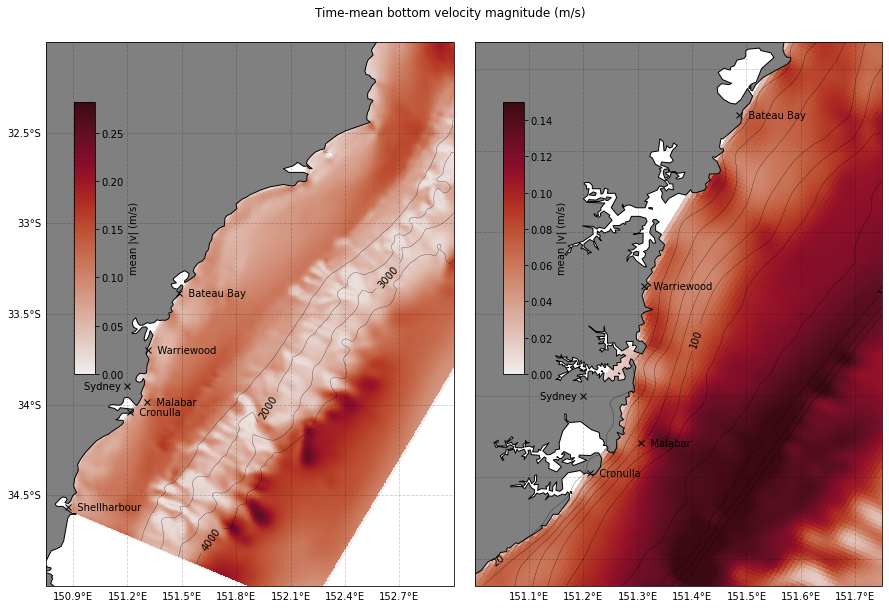

In [17]:


gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([150.75, 153, -35, -32])
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im = ds.vmag.isel(s_rho=0).mean(dim='ocean_time').plot(x='lon_rho',y='lat_rho',cmap='cmo.amp', add_colorbar=False)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)

ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')
ax.text(151.486467,-33.384367,'   Bateau Bay  ',ha='left',va='center'), ax.plot(151.486467,-33.384367,marker='x',color='k')
ax.text(151.311883,-33.69805,'   Warriewood  ',ha='left',va='center'), ax.plot(151.311883,-33.69805,marker='x',color='k')
ax.text(151.306667,-33.987,'   Malabar  ',ha='left',va='center'), ax.plot(151.306667,-33.987,marker='x',color='k')
ax.text(151.212333,-34.043083,'   Cronulla  ',ha='left',va='center'), ax.plot(151.212333,-34.043083,marker='x',color='k')
ax.text(150.87365,-34.563683,'   Shellharbour  ',ha='left',va='center'), ax.plot(150.87365,-34.563683,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('mean |v| (m/s)')
ax.set_title('')  

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax.set_extent([151, 151.75, -34.25, -33.25])
feature = ax.add_feature(coastHR, edgecolor='black',facecolor='gray')
im = ds.vmag.isel(s_rho=0).mean(dim='ocean_time').plot(x='lon_rho',y='lat_rho',cmap='cmo.amp', add_colorbar=False,vmin=0,vmax=.15)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=np.arange(0,220,20),linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)

ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')
ax.text(151.486467,-33.384367,'   Bateau Bay  ',ha='left',va='center'), ax.plot(151.486467,-33.384367,marker='x',color='k')
ax.text(151.311883,-33.69805,'   Warriewood  ',ha='left',va='center'), ax.plot(151.311883,-33.69805,marker='x',color='k')
ax.text(151.306667,-33.987,'   Malabar  ',ha='left',va='center'), ax.plot(151.306667,-33.987,marker='x',color='k')
ax.text(151.212333,-34.043083,'   Cronulla  ',ha='left',va='center'), ax.plot(151.212333,-34.043083,marker='x',color='k')
# ax.text(150.87365,-34.563683,'   Shellharbour  ',ha='left',va='center'), ax.plot(150.87365,-34.563683,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('mean |v| (m/s)')
fig.suptitle('Time-mean bottom velocity magnitude (m/s)',y=0.93)  


Text(0.5, 0.93, 'RMS bottom velocity magnitude (m/s)')

<Figure size 432x288 with 0 Axes>

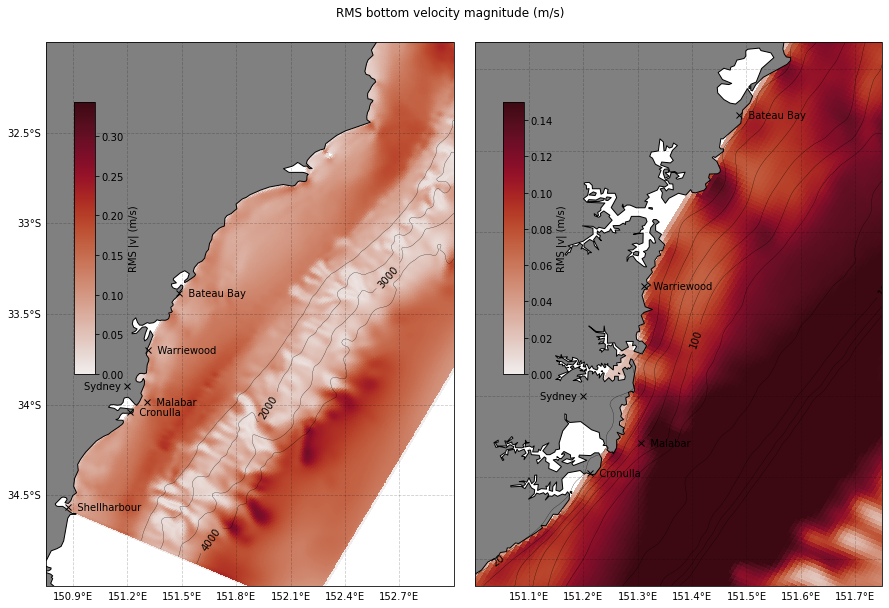

In [18]:


gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([150.75, 153, -35, -32])
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im = ds.vmag_rms.isel(s_rho=0).plot(x='lon_rho',y='lat_rho',cmap='cmo.amp', add_colorbar=False)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)

ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')
ax.text(151.486467,-33.384367,'   Bateau Bay  ',ha='left',va='center'), ax.plot(151.486467,-33.384367,marker='x',color='k')
ax.text(151.311883,-33.69805,'   Warriewood  ',ha='left',va='center'), ax.plot(151.311883,-33.69805,marker='x',color='k')
ax.text(151.306667,-33.987,'   Malabar  ',ha='left',va='center'), ax.plot(151.306667,-33.987,marker='x',color='k')
ax.text(151.212333,-34.043083,'   Cronulla  ',ha='left',va='center'), ax.plot(151.212333,-34.043083,marker='x',color='k')
ax.text(150.87365,-34.563683,'   Shellharbour  ',ha='left',va='center'), ax.plot(150.87365,-34.563683,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('RMS |v| (m/s)')
ax.set_title('')  

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax.set_extent([151, 151.75, -34.25, -33.25])
feature = ax.add_feature(coastHR, edgecolor='black',facecolor='gray')
im = ds.vmag_rms.isel(s_rho=0).plot(x='lon_rho',y='lat_rho',cmap='cmo.amp', add_colorbar=False,vmin=0,vmax=.15)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=np.arange(0,220,20),linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)

ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')
ax.text(151.486467,-33.384367,'   Bateau Bay  ',ha='left',va='center'), ax.plot(151.486467,-33.384367,marker='x',color='k')
ax.text(151.311883,-33.69805,'   Warriewood  ',ha='left',va='center'), ax.plot(151.311883,-33.69805,marker='x',color='k')
ax.text(151.306667,-33.987,'   Malabar  ',ha='left',va='center'), ax.plot(151.306667,-33.987,marker='x',color='k')
ax.text(151.212333,-34.043083,'   Cronulla  ',ha='left',va='center'), ax.plot(151.212333,-34.043083,marker='x',color='k')
# ax.text(150.87365,-34.563683,'   Shellharbour  ',ha='left',va='center'), ax.plot(150.87365,-34.563683,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('RMS |v| (m/s)')
ax.set_title('')  
fig.suptitle('RMS bottom velocity magnitude (m/s)',y=0.93)  


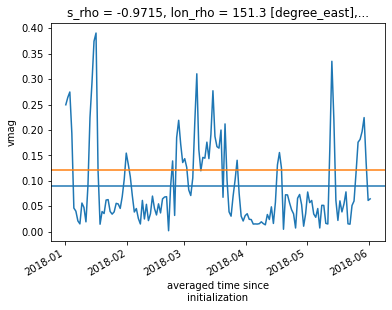

In [33]:
ds.vmag.isel(eta_rho=103,xi_rho=24,s_rho=0).plot()
plt.axhline(ds.vmag.isel(eta_rho=103,xi_rho=24,s_rho=0).mean(dim='ocean_time'))
plt.axhline(ds.vmag_rms.isel(eta_rho=103,xi_rho=24,s_rho=0),color='C1')

plt.show()

#### now some time vs. profiles at a chosen location

In [22]:
station_lon = 151.306667
station_lat = -33.987
closest_approach = (np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).argmin(dim=['eta_rho','xi_rho'])
eta_station = closest_approach['eta_rho'].values
xi_station = closest_approach['xi_rho'].values

In [24]:
eta_station

array(103)

In [25]:
xi_station

array(24)

In [ ]:
# ds["rho"] = rho_eos(ds.temp,ds.salt,ds.z_rho)

In [ ]:


gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5.5])
ax = None

ax = fig.add_subplot(gs[0,0])

ds.temp.isel(eta_rho=103,xi_rho=24).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.thermal',levels=np.arange(16,24,.5))

ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential temperature at Malabar')

In [ ]:

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5.5])
ax = None

ax = fig.add_subplot(gs[0,0])
ds.rho.isel(eta_rho=103,xi_rho=24).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.dense',levels=np.arange(1023,1027.25,.25))

ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential density (kg/m$^{3}$) at Malabar')

In [ ]:
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5.5])
ax = None

ax = fig.add_subplot(gs[0,0])
ds.vmag.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.amp',levels=np.arange(0,1,.1))

ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Velocity magnitude (m/s) at Malabar')

#### Wind stress and Ekman upwelling

In [ ]:
omega = 7.29e-5
f = 2 * omega * np.sin(np.deg2rad(ds.lat_rho))
rho0 = 1030
ds['U_ek'] = grid.interp(ds.sustr,'X',boundary='fill') / (rho0 * f)
ds['V_ek'] = -grid.interp(ds.svstr,'Y',boundary='fill') / (rho0 * f)


In [ ]:
# now calculate vertical velocities
ds['W_ek'] = grid.interp(grid.diff(ds.U_ek,'X',boundary='fill'),'X',boundary='fill') + grid.interp(grid.diff(ds.V_ek,'Y',boundary='fill'),'Y',boundary='fill')

In [ ]:


gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([150.75, 153, -35, -32])
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
# im = (((ds.W_ek**2).mean(dim='ocean_time'))**0.5).plot(x='lon_rho',y='lat_rho',cmap='cmo.curl', add_colorbar=False,vmin=-.1,vmax=0.1)     
im = (((ds.W_ek**1).mean(dim='ocean_time'))**1).plot(x='lon_rho',y='lat_rho',cmap='cmo.curl', add_colorbar=False,vmin=-.03,vmax=0.03)     

co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)

ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')
ax.text(151.486467,-33.384367,'   Bateau Bay  ',ha='left',va='center'), ax.plot(151.486467,-33.384367,marker='x',color='k')
ax.text(151.311883,-33.69805,'   Warriewood  ',ha='left',va='center'), ax.plot(151.311883,-33.69805,marker='x',color='k')
ax.text(151.306667,-33.987,'   Malabar  ',ha='left',va='center'), ax.plot(151.306667,-33.987,marker='x',color='k')
ax.text(151.212333,-34.043083,'   Cronulla  ',ha='left',va='center'), ax.plot(151.212333,-34.043083,marker='x',color='k')
ax.text(150.87365,-34.563683,'   Shellharbour  ',ha='left',va='center'), ax.plot(150.87365,-34.563683,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Upwelling w (m/s)')
ax.set_title('')  

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax.set_extent([151, 151.75, -34.25, -33.25])
feature = ax.add_feature(coastHR, edgecolor='black',facecolor='gray')
# im = (((ds.W_ek**2).mean(dim='ocean_time'))**0.5).plot(x='lon_rho',y='lat_rho',cmap='cmo.curl', add_colorbar=False,vmin=-.1,vmax=.1)  
im = (((ds.W_ek).mean(dim='ocean_time'))).plot(x='lon_rho',y='lat_rho',cmap='cmo.curl', add_colorbar=False,vmin=-.03,vmax=.03)     

co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=np.arange(0,220,20),linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)

ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')
ax.text(151.486467,-33.384367,'   Bateau Bay  ',ha='left',va='center'), ax.plot(151.486467,-33.384367,marker='x',color='k')
ax.text(151.311883,-33.69805,'   Warriewood  ',ha='left',va='center'), ax.plot(151.311883,-33.69805,marker='x',color='k')
ax.text(151.306667,-33.987,'   Malabar  ',ha='left',va='center'), ax.plot(151.306667,-33.987,marker='x',color='k')
ax.text(151.212333,-34.043083,'   Cronulla  ',ha='left',va='center'), ax.plot(151.212333,-34.043083,marker='x',color='k')
# ax.text(150.87365,-34.563683,'   Shellharbour  ',ha='left',va='center'), ax.plot(150.87365,-34.563683,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Upwelling w (m/s)')
ax.set_title('')  
fig.suptitle('Time-mean Ekman upwelling (m/s)',y=0.93)  




In [ ]:


gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5.5])
ax = None

ax = fig.add_subplot(gs[0,0])

ds.W_ek.isel(eta_rho=eta_station,xi_rho=xi_station).plot(x='ocean_time')
ax.axhline(0,color='k',zorder=-10)
ax.grid()
ax.set_ylim(-.06,.06)
ax.set_ylabel('Ekman upwelling (m/s)')
ax.set_title('Ekman upwelling at Malabar [positive] and downwelling [negative] (m/s)')

In [ ]:
ds.ocean_time
